In [1]:
symbol = input("Enter the symbol : ")

In [2]:
from nse import *
from finta import TA
import pandas as pd
import numpy as np
from sklearn import preprocessing
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
today = datetime.now()
oneyearago = today - timedelta(days=365*10)

date_format = "%d-%m-%Y"

df = scrape_data(f"{oneyearago.strftime(date_format)}",f"{today.strftime(date_format)}",symbol)
rawdata = df.copy()
df.head()

,Date,Symbol,Series,High Price,Low Price,Open Price,Close Price,Last Price,Prev Close Price,Total Traded Quantity,Total Traded Value,52 Week High Price,52 Week Low Price
0,2021-11-18,PAYTM,EQ,1955.0,1560.00,1950.0,1560.80,1560.0,2150.00,23955434,4.087011e+10,1955.0,1560.0
1,2021-11-22,PAYTM,EQ,1519.0,1271.00,1509.0,1359.60,1362.0,1560.80,25114710,3.468406e+10,1955.0,1271.0
2,2021-11-23,PAYTM,EQ,1525.0,1360.00,1360.0,1494.70,1489.8,1359.60,12954174,1.896220e+10,1955.0,1271.0
3,2021-11-24,PAYTM,EQ,1785.0,1502.95,1503.0,1752.45,1753.0,1494.70,21541021,3.606648e+10,1955.0,1271.0
4,2021-11-25,PAYTM,EQ,1873.7,1711.10,1766.7,1798.75,1785.0,1752.45,13018344,2.340361e+10,1955.0,1271.0


In [4]:
df = df[['Date','High Price', 'Low Price', 'Open Price','Close Price', 'Total Traded Quantity']]
df.columns = ['Date','High', 'Low', 'Open','Close', 'Volume']
df.head()

,Date,High,Low,Open,Close,Volume
0,2021-11-18,1955.0,1560.00,1950.0,1560.80,23955434
1,2021-11-22,1519.0,1271.00,1509.0,1359.60,25114710
2,2021-11-23,1525.0,1360.00,1360.0,1494.70,12954174
3,2021-11-24,1785.0,1502.95,1503.0,1752.45,21541021
4,2021-11-25,1873.7,1711.10,1766.7,1798.75,13018344


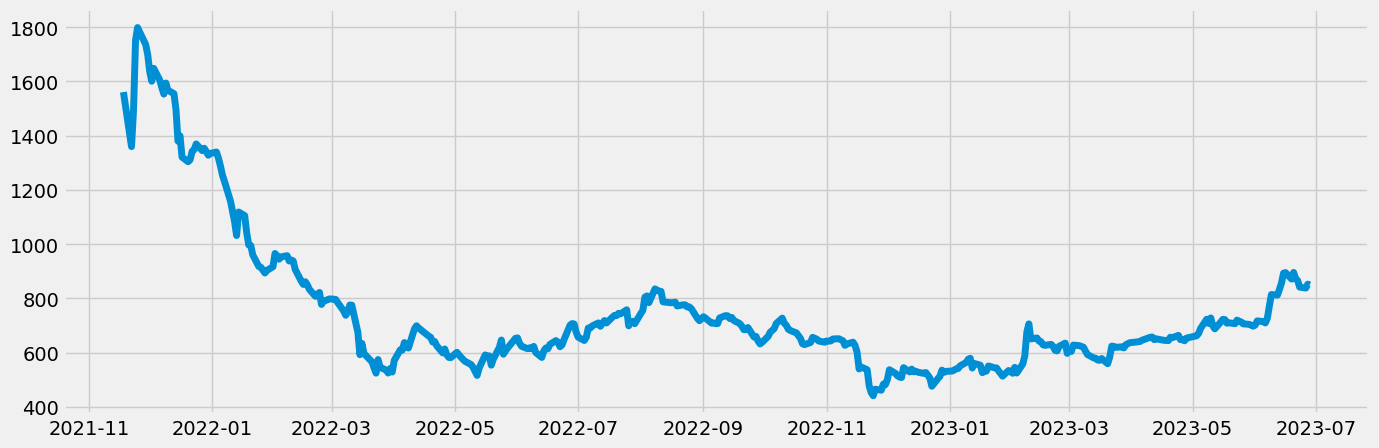

In [5]:
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(df['Date'],df['Close'],label="Close", linestyle="-", linewidth=5)

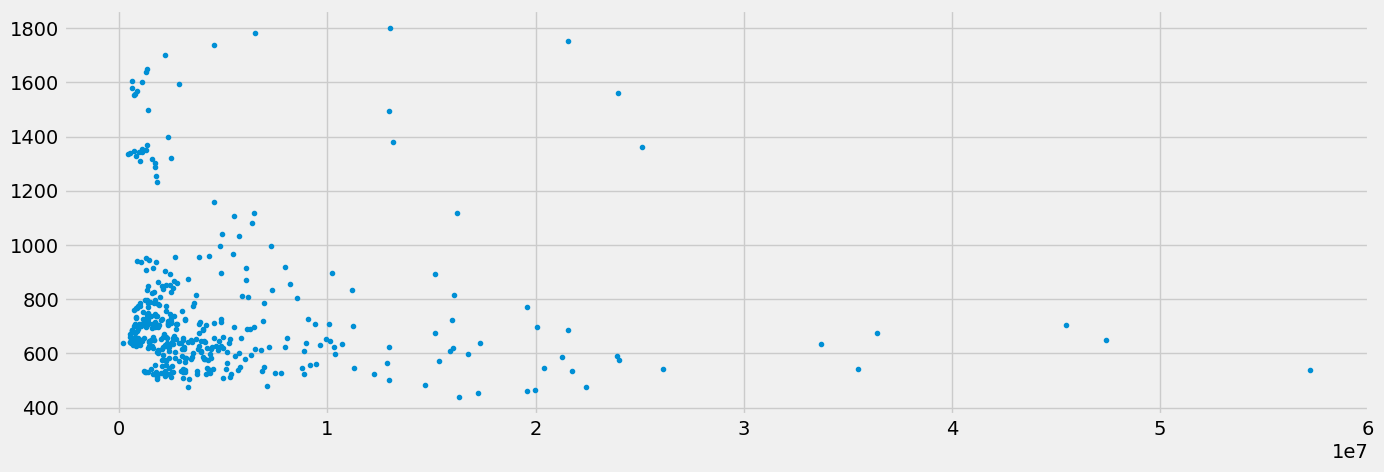

In [6]:
plt.plot(df['Volume'],df['Close'],linestyle="", marker=".")

In [7]:
def on_balance_volume_indicator(stock_df):
    new_df = pd.DataFrame({})
    new_df = stock_df[['Close']].copy()

    new_balance_volume = [0]
    tally = 0

    for i in range(1, len(new_df)):
        if (stock_df['Close'][i] > stock_df['Close'][i - 1]):
            tally += stock_df['Volume'][i]
        elif (stock_df['Close'][i] < stock_df['Close'][i - 1]):
            tally -= stock_df['Volume'][i]
        new_balance_volume.append(tally)

    new_df['OnBalanceVolume'] = new_balance_volume
    minimum = min(new_df['OnBalanceVolume'])

    new_df['OnBalanceVolume'] = new_df['OnBalanceVolume'] - minimum
    new_df['OnBalanceVolume'] = (new_df['OnBalanceVolume']+1).transform(np.log)

    return new_df

def add_technical_indicators(stock_df):
    edited_df = pd.DataFrame()

    edited_df['open'] = stock_df['Open']
    edited_df['high'] = stock_df['High']
    edited_df['low'] = stock_df['Low']
    edited_df['close'] = stock_df['Close']
    edited_df['volume'] = stock_df['Volume']
    edited_df.head()

    ema = TA.EMA(edited_df)
    bb = TA.BBANDS(edited_df)

    stock_df['EMA'] = ema.copy()

    #Adding of features to the dataframe
    new_df = pd.concat([stock_df, bb], axis = 1)

    #Filling of missing data as Bollinger Bands is based on a 21 day EMA

    # TODO: Uncomment
#     for i in range(19):
#         new_df['BB_MIDDLE'][i] = new_df.loc[i, 'EMA']
    
#         if i != 0:
#             higher = new_df.loc[i, 'BB_MIDDLE'] + 2 * new_df['Close'].rolling(i + 1).std()[i]
#             lower = new_df.loc[i, 'BB_MIDDLE'] - 2 * new_df['Close'].rolling(i + 1).std()[i]
#             new_df['BB_UPPER'][i] = higher
#             new_df['BB_LOWER'][i] = lower
#         else:
#             new_df['BB_UPPER'][i] = new_df.loc[i, 'BB_MIDDLE']
#             new_df['BB_LOWER'][i] = new_df.loc[i, 'BB_MIDDLE']
    
    new_df.dropna()
            
    new_df = on_balance_volume_indicator(new_df)
    
    return new_df

In [8]:
def train_test_split_preparation(new_df, data_set_points, train_split):
    new_df = new_df.loc[1:]

    #Preparation of train test set.
    train_indices = int(new_df.shape[0] * train_split)

    train_data = new_df[:train_indices]
    test_data = new_df[train_indices:]
    test_data = test_data.reset_index()
    test_data = test_data.drop(columns = ['index'])
    
    train_arr = np.diff(train_data.loc[:, ['Close']].values, axis = 0)
    test_arr = np.diff(test_data.loc[:, ['Close']].values, axis = 0)


    X_train = np.array([train_arr[i : i + data_set_points] for i in range(len(train_arr) - data_set_points)])


    y_train = np.array([train_arr[i + data_set_points] for i in range(len(train_arr) - data_set_points)])

    y_valid = np.array([train_data['Close'][-(int)(len(y_train)/10):].copy()])

    y_valid = y_valid.flatten()
    y_valid = np.expand_dims(y_valid, -1)

    X_test = np.array([test_arr[i : i + data_set_points] for i in range(len(test_arr) - data_set_points)])

    y_test = np.array([test_data['Close'][i + data_set_points] for i in range(len(test_arr) - data_set_points)])


    return X_train, y_train, X_test, y_test, test_data

In [9]:
train_split = 0.7

data_set_points = 21

new_df = df[['Close']].copy()

#Train test split

X_train, y_train, X_test, y_test, test_data = train_test_split_preparation(new_df, data_set_points, train_split)
X_train[0]

array([[ 135.1 ],
       [ 257.75],
       [  46.3 ],
       [ -16.15],
       [ -46.15],
       [ -36.85],
       [ -62.9 ],
       [ -35.85],
       [  47.5 ],
       [ -43.9 ],
       [ -26.95],
       [ -24.1 ],
       [  40.55],
       [ -26.4 ],
       [ -12.5 ],
       [ -59.  ],
       [-116.1 ],
       [  19.4 ],
       [ -78.35],
       [ -17.  ],
       [   7.45]])

In [10]:
import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
from sklearn.metrics import mean_squared_error
tf.random.set_seed(20)
np.random.seed(10)

lstm_input = Input(shape=(data_set_points, 1), name='input_for_lstm')

inputs = LSTM(21, name='first_layer', return_sequences = True)(lstm_input)

inputs = Dropout(0.1, name='first_dropout_layer')(inputs)
inputs = LSTM(32, name='lstm_1')(inputs)
inputs = Dropout(0.05, name='lstm_dropout_1')(inputs) #Dropout layers to prevent overfitting
inputs = Dense(32, name='first_dense_layer')(inputs)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam(learning_rate = 0.002)

model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=25, shuffle=True, validation_split = 0.1)

Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
16/16 [==============================] - ETA: 0s - loss: 591.3043WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000019D4B6B7670> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause

In [11]:
y_pred = model.predict(X_test)

y_pred = y_pred.flatten()

#actual represents the test set's actual stock prices
actual = np.array([test_data['Close'][i + data_set_points].copy() for i in range(len(test_data) - data_set_points)])

#reference represents the stock price of the point before the prediction, so we can iteratively add the difference
reference = test_data['Close'][data_set_points - 1]

predicted = []

predicted.append(reference)

#adding of difference and appending to the list
for i in y_pred:
    reference += i
    predicted.append(reference)

predicted = np.array(predicted)

print(predicted)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - 1s 5ms/step
[523.85       525.89846406 531.38362584 533.3241596  534.5962858
 536.23719773 533.66344151 522.4444159  525.17653642 528.53667722
 528.88381374 534.11325348 537.29662955 538.00078637 524.20062215
 504.27089269 483.95122868 483.23509491 482.18867744 480.66481007
 479.30579627 478.49656731 476.81413037 476.15672494 475.7172685
 473.03263835 4

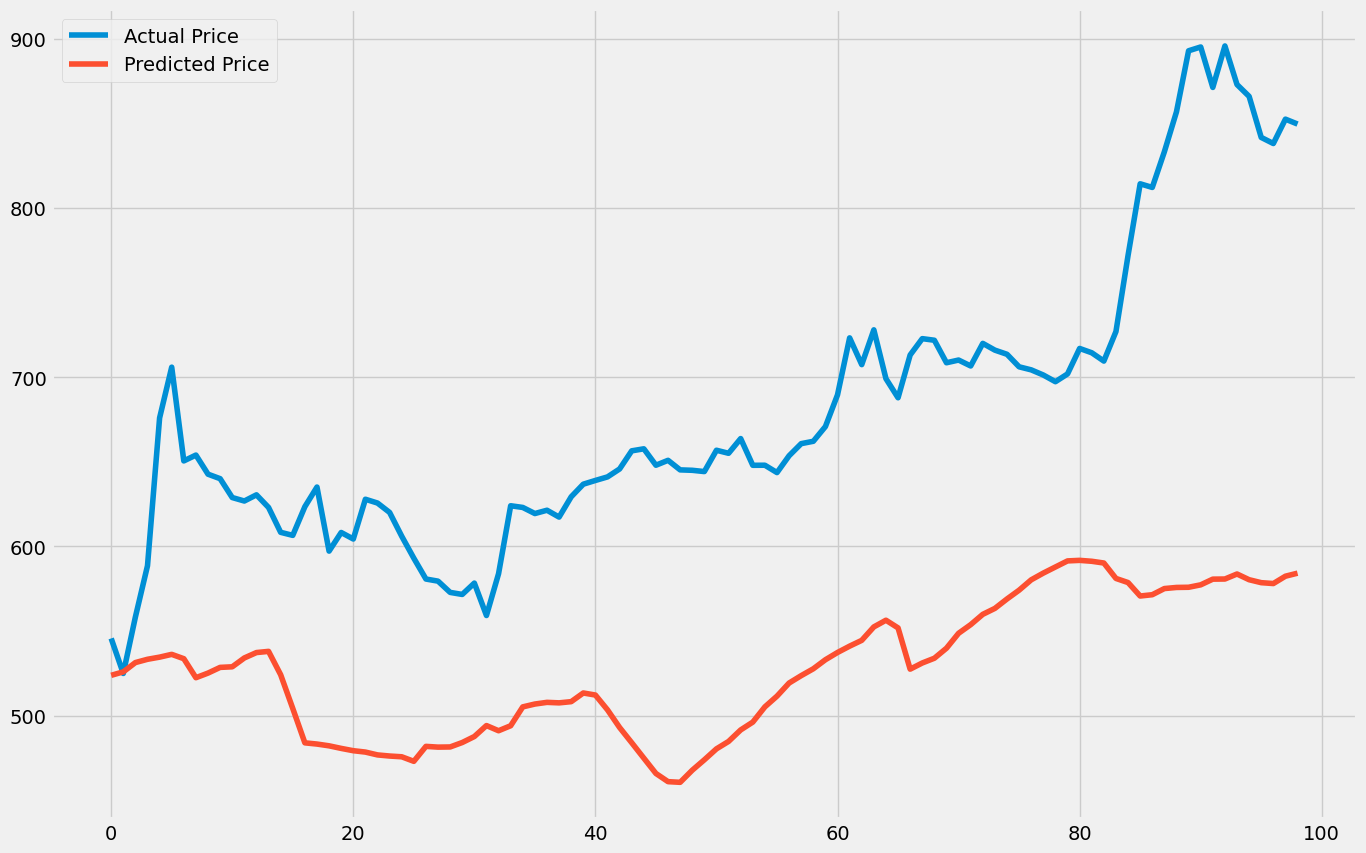

In [12]:
real = plt.plot(actual, label='Actual Price')
pred = plt.plot(predicted, label='Predicted Price')

plt.legend(['Actual Price', 'Predicted Price'])
plt.gcf().set_size_inches(15, 10, forward=True)

plt.show()

In [13]:
pred_df = pd.DataFrame()
pred_df['Predictions'] = predicted


y_pct_change = pred_df.pct_change()

money = 10000
number_of_stocks = (int)(10000 / actual[0])
left = 10000 - (int)(10000 / actual[0]) * actual[0] + actual[len(actual) - 1] * number_of_stocks

number_of_stocks = 0

buying_percentage_threshold = 0.01 #as long as we have a 0.15% increase/decrease we buy/sell the stock
selling_percentage_threshold = 0.01

for i in range(len(actual) - 1):    
    if y_pct_change['Predictions'][i + 1] > buying_percentage_threshold:
        for j in range(100, 0, -1):
            #Buying of stock
            if (money >= j * actual[i]):
                money -= j * actual[i]
                number_of_stocks += j
                break
    elif  y_pct_change['Predictions'][i + 1] < -selling_percentage_threshold:
        for j in range(100, 0, -1):
            #Selling of stock
            if (number_of_stocks >= j):
                money += j * actual[i]
                number_of_stocks -= j
                break

money += number_of_stocks * actual[len(actual) - 1]

print(money) #Money if we traded
print(left)  #Money if we just bought as much at the start and sold near the end (Buy and hold)


13923.699999999997
15471.100000000002


20.27554047304974


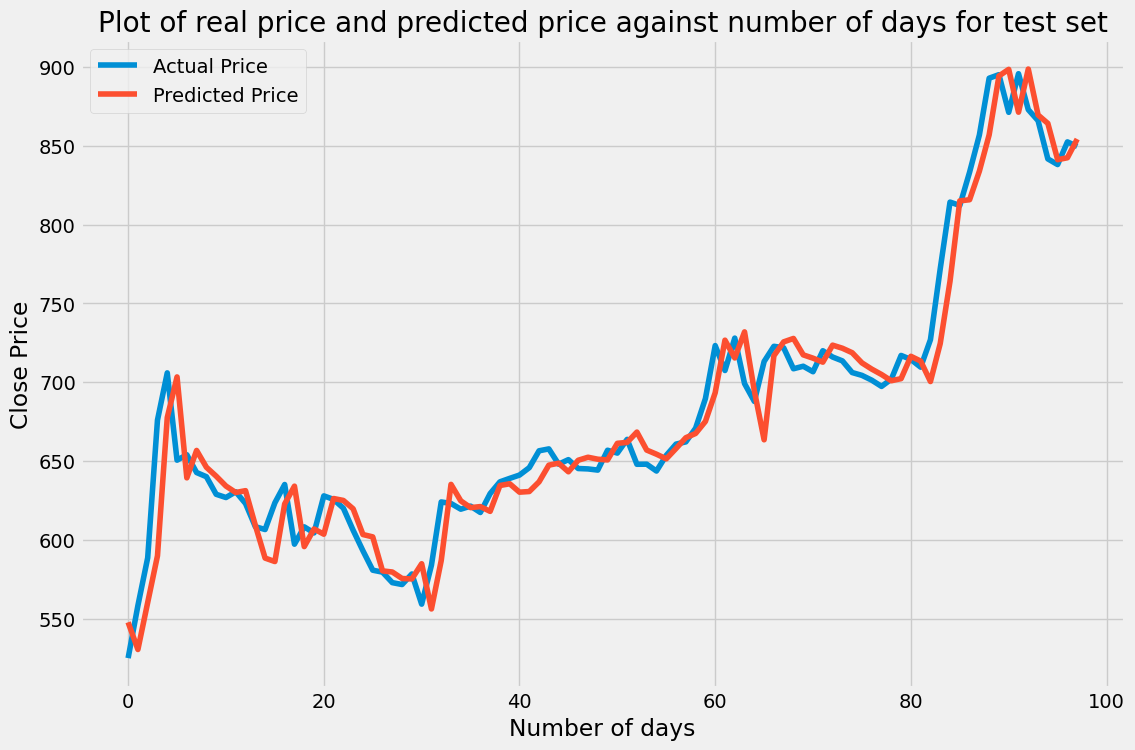

In [14]:
temp_actual = actual[:-1]

#Adding each actual price at time t with the predicted difference to get a predicted price at time t + 1
new = np.add(temp_actual, y_pred)

plt.gcf().set_size_inches(12, 8, forward=True)
plt.title('Plot of real price and predicted price against number of days for test set')
plt.xlabel('Number of days')
plt.ylabel('Close Price')

plt.plot(actual[1:], label='Actual Price')
plt.plot(new, label='Predicted Price')

print(mean_squared_error(actual[1:], new, squared = False))

#plotting of model  
plt.legend(['Actual Price', 'Predicted Price'])


plt.show()

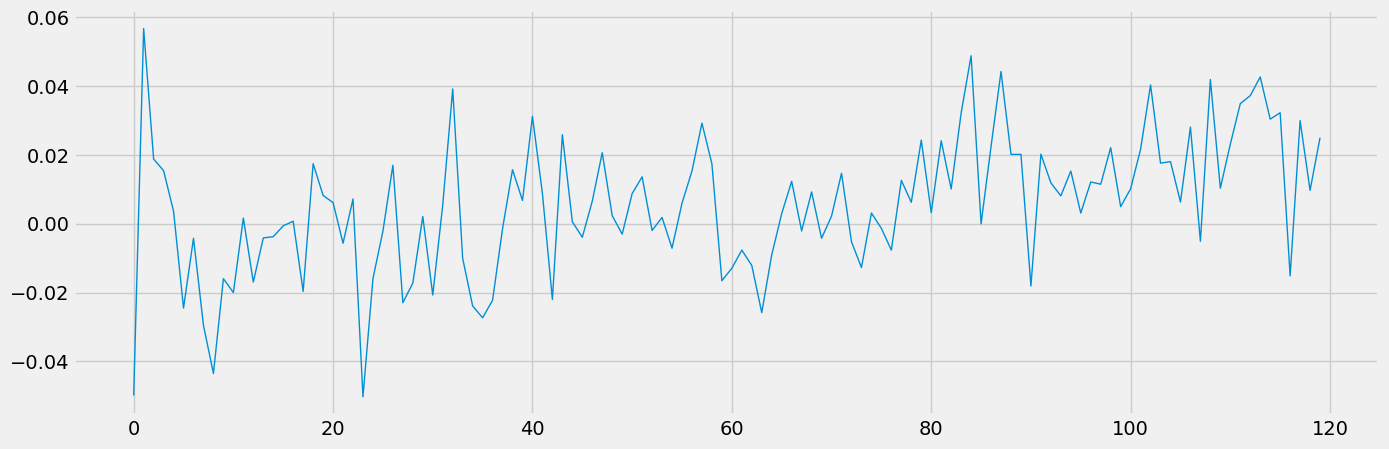

In [35]:
change = pd.DataFrame((actual[1:] - new)/100, columns=["diff"])
plt.plot(change, linewidth=1)
plt.show()

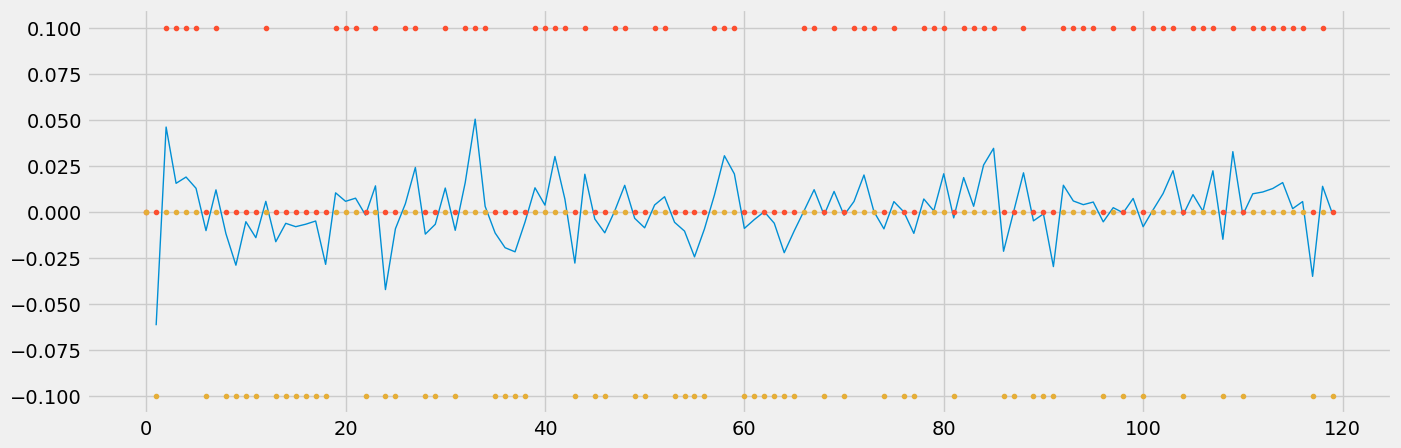

In [36]:
ne = pd.DataFrame(new, columns=["diff"])

desc = (ne - ne.shift(+1))/100
desc["buy"] = (desc['diff'] > 0).astype(float) * 0.1
desc["sell"] = (desc['diff'] < 0).astype(float) * -0.1
plt.plot(desc["diff"], linewidth=1)
plt.plot(desc["buy"], linestyle="", marker=".")
plt.plot(desc["sell"], linestyle="", marker=".")
plt.show()

In [39]:
np.add(new_df.tail(21).to_numpy().reshape(1,21), np.array(y_pred[-21:]))

array([[62.00127864, 61.88247986, 63.53091617, 66.11180453, 65.43605733,
        65.14244709, 65.96745167, 68.43793015, 67.35751964, 70.15540608,
        70.31433558, 71.13571105, 73.15572572, 73.37289386, 75.12872086,
        75.25724382, 75.41955857, 71.41649113, 73.10025547, 72.826477  ,
        74.74472616]])

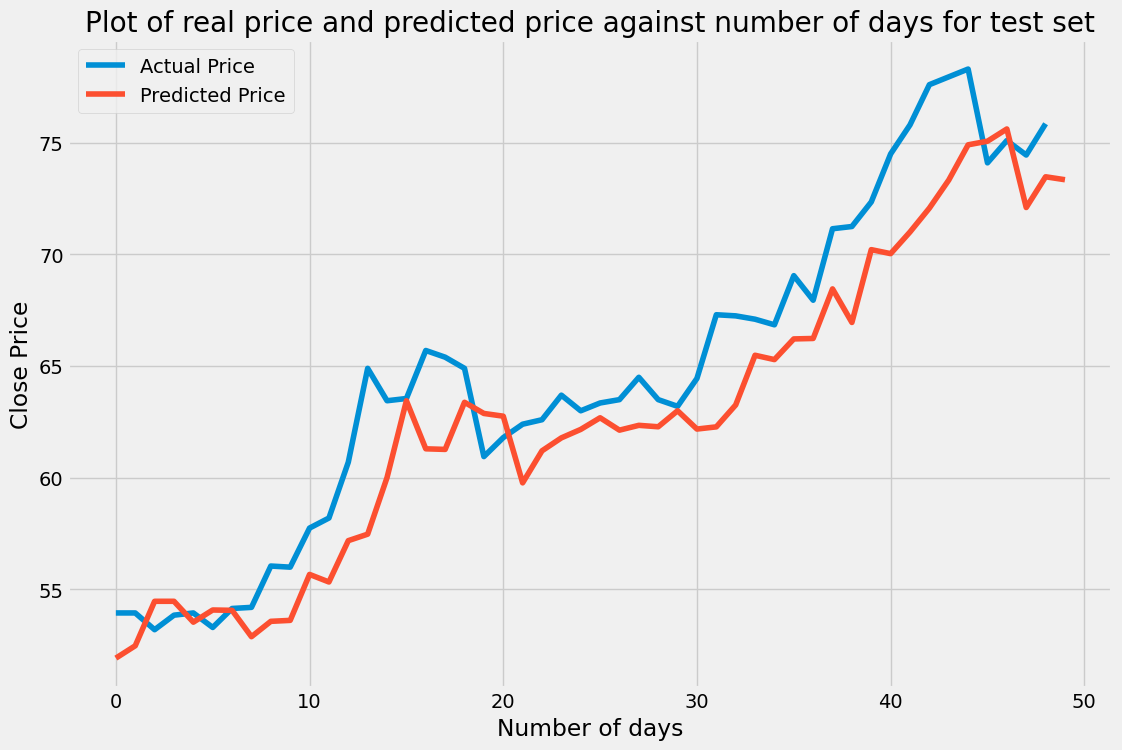

In [40]:
days = 50
temp_actual = actual[-days-1:-1]

new = np.add(temp_actual, y_pred[-days:])

plt.gcf().set_size_inches(12, 8, forward=True)
plt.title('Plot of real price and predicted price against number of days for test set')
plt.xlabel('Number of days')
plt.ylabel('Close Price')

plt.plot(actual[-days+1:], label='Actual Price')
plt.plot(new, label='Predicted Price')

#plotting of model  
plt.legend(['Actual Price', 'Predicted Price'])


plt.show()

In [41]:
np.array(y_pred[-21:])

array([-1.4987214 , -1.3175201 , -0.91908383, -1.1881955 , -1.8139427 ,
       -1.9575529 , -0.88254833, -0.61206985, -0.59248036, -0.9945939 ,
       -0.9356644 , -1.214289  , -1.3442743 , -2.4271061 , -2.4712791 ,
       -2.6927562 , -2.8804414 , -2.6835089 , -1.9997445 , -1.623523  ,
       -1.1052738 ], dtype=float32)